# Load pytorch library

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Define validation dataset ratio

In [0]:

valid_ratio = 0.3

# Define the Cifar 10 training and validation sets, and possible transforms to be applied. Optional augmentation can be done within the transform. 

In [0]:
transform = transforms.Compose(
    [
     #transforms.RandomRotation(degrees=0.1),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_valid_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                                   download=True, transform=transform)

nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=500,
                                          shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=500,
                                          shuffle=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


# Visualize the Cifar 10 dataset.

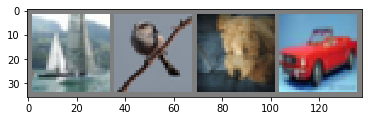

 ship  bird   dog   car


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4,]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Construct the CNN.

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0)
        #self.conv4 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=0)
        #self.conv5 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(16*6*6, 512)
        #self.fc1 = nn.Linear(24*2*2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #x = F.relu(self.conv4(x))
        #x = F.relu(self.conv5(x))
        #print(x.shape)
        x = x.view(-1, 16*6*6)
        #x = x.view(-1, 24*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



# Instantiate the CNN and print out the number of parameters.

In [0]:
net = Net()
print(sum([p.numel() for p in net.parameters()]))

366090


# Define the loss function and the optimizer.

In [0]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.004905)
#optimizer = optim.SGD(net.parameters(), lr=0.1)

# Select the device to train the CNN! "cuda:0" means the first GPU device.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

# Mount your google drive to current virtual machine. And define the path to store the trained CNN parameters.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
PATH = 'drive/My Drive/ML19/cifar_net.pth'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train the CNN and store the best model based on the validation loss.

Epoch:  0  train loss:  1.839
Epoch:  0  validation loss:  1.541
Epoch:  1  train loss:  1.434
Epoch:  1  validation loss:  1.357
Epoch:  2  train loss:  1.278
Epoch:  2  validation loss:  1.233
Epoch:  3  train loss:  1.153
Epoch:  3  validation loss:  1.186
Epoch:  4  train loss:  1.071
Epoch:  4  validation loss:  1.133
Epoch:  5  train loss:  0.993
Epoch:  5  validation loss:  1.063
Epoch:  6  train loss:  0.927
Epoch:  6  validation loss:  1.048
Epoch:  7  train loss:  0.858
Epoch:  7  validation loss:  1.079
Epoch:  8  train loss:  0.793
Epoch:  8  validation loss:  1.058
Epoch:  9  train loss:  0.719
Epoch:  9  validation loss:  1.007
Finished Training in 1 mins


Text(0, 0.5, 'Loss')

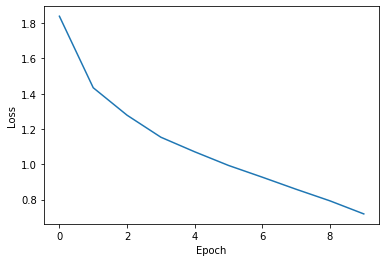

In [0]:
import time
epoch_lossList = []
valid_lossList = []
j = 0
start_time = time.time()
best_loss = np.float('inf')
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss / (i+1)
    epoch_lossList.append(epoch_loss)
    print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)
    with torch.no_grad(): 
      running_loss = 0.0
      for i, data in enumerate(validloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # forward 
          outputs = net(inputs)
          loss = criterion(outputs, labels)

          # print statistics
          running_loss += loss.item()
      epoch_loss = running_loss / (i+1)
      valid_lossList.append(epoch_loss)
      print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)
      if epoch_loss < best_loss:
        torch.save(net.state_dict(), PATH)
        best_loss = epoch_loss
    #if valid_lossList[j] > valid_lossList[j-1]:
    # break
    #j += 1
time_elap = (time.time() - start_time) // 60
print('Finished Training in %d mins' % time_elap)
plt.plot(epoch_lossList)
#plt.plot(valid_lossList)
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Define the test dataset.

In [0]:
transform = transforms.Compose(
     [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)

Files already downloaded and verified


# Visualize the test dataset.

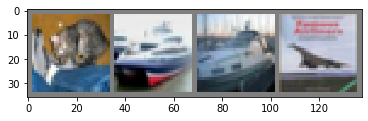

GroundTruth:    cat  ship  ship plane


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Load the learned CNN parameters. This is required when you have trained the CNN and do no want to train it again by loading the learned parameters.

In [0]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Get the predictions for the first 4 images in the test dataset.

In [0]:
with torch.no_grad():
  outputs = net(images.to(device))
  _, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship  ship  ship plane


# Infer on the whole test dataset.

In [0]:
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=1)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %.3F %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65.820 %


# check the GPU device assigned by Google.

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Thu Dec 19 01:31:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    33W / 250W |    923MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  